# Feature selection
#### importing libraries and reading in data

In [1]:
import csv
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from graphviz import Source # for drawing decision tree
from IPython.display import SVG # for drawing decision tree

motifNames = []
classes = []
rawData = []
with open('../../coadreadDAThugocombine.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    motifNames = next(readCSV)[1:-1] #remove left most column and 'class'
    for row in readCSV:
        #NOTE !! THIS AFFECTS THE RESULT. USE IF 3 CLASSES
        if(float(row[-1]) == 11.0):
            continue
        if(float(row[-1]) == 2.0):
            row[-1] = -1.0
        rawData.append(row[1:-1])
        classes.append(row[-1])
print ("number of motif names:", len(motifNames)) 
print ("number of recorded classes:", len(classes))  
print ("Data Dimentions:", len(rawData),"rows,", len(rawData[0]), "cols")
print(motifNames)

number of motif names: 15947
number of recorded classes: 224
Data Dimentions: 224 rows, 15947 cols
['TP53', 'ASCC1', 'POLR3B', 'ARHGEF7', 'FREM2', 'UNC79', 'NFATC2IP', 'FA2H', 'BPTF', 'WDR16', 'USHBP1', 'ZNF254', 'PODNL1', 'AMPD1', 'EPRS', 'SYTL1', 'KCNS3', 'BMPR2', 'DNMT3A', 'CRIM1', 'IFT80', 'NLGN1', 'GRM7', 'GABRA4', 'CYTL1', 'KIT', 'LAMA2', 'OR2F1', 'TG', 'HSF1', 'APC', 'AXIN2', 'ADCY5', 'SLC25A4', 'CCDC28A', 'BRAF', 'ZHX2', 'USP26', 'LOXL4', 'CPN1', 'CNNM2', 'MXI1', 'VTI1A', 'NSMCE4A', 'CPXM2', 'FANK1', 'C10orf90', 'CUBN', 'YME1L1', 'ZEB1', 'DIP2C', 'VSTM4', 'CSTF2T', 'HERC4', 'MYPN', 'DDX50', 'SAMD8', 'ITIH5', 'COMTD1', 'MAT1A', 'GRID1', 'IFIT5', 'MARCH5', 'SORBS1', 'MSANTD4', 'RAB39A', 'BACE1', 'KMT2A', 'USP2', 'ROBO4', 'KCNJ1', 'CYP2R1', 'KCNC1', 'ODF3', 'ANO5', 'GAS2', 'MUC15', 'WT1', 'CAPRIN1', 'CAT', 'PRR5L', 'B4GALNT4', 'LRRC4C', 'APLNR', 'CD6', 'VWCE', 'AHNAK', 'MTA2', 'INTS5', 'DPF2', 'YIF1A', 'CTD-3074O7.11', 'SPTBN2', 'LRP5', 'NLRP14', 'DHCR7', 'NUMA1', 'DNAJB13', 'SLCO

#### Transpose data and convert to true / false for simpler code

In [2]:
# convert data to T/F
for row in range(len(rawData)):
        for cell in range(len(rawData[row])):
            if(rawData[row][cell] == '0.0'): # DONT CHANGE
                rawData[row][cell] = False
            elif(rawData[row][cell] == '1.0'): # DONT CHANGE
                rawData[row][cell] = True
                
# convert data to T/F
for cell in range(len(classes)):
    if(classes[cell] == '-1.0'): # Y-Axis
        classes[cell] = False
    elif(classes[cell] == '1.0'): # X-Axis
        classes[cell] = True

    
# transpose data
tData = [list(i) for i in zip(*rawData)]
print ("Transposed Dimentions:", len(tData),"rows,", len(tData[0]), "cols")  

Transposed Dimentions: 15947 rows, 224 cols


Count how many times each motif occurs in the positive and negative classes

In [3]:
#add jitter
import numpy as np
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

posCounts = []
negCounts = []

for row in range(len(tData)):
    posCount = 0
    negCount = 0
    for col in range(len(tData[row])):
        if(tData[row][col] == True):
            if(classes[col] == True):
                posCount += 1 
            elif(classes[col] == False):
                negCount += 1
    posCounts.append(posCount)
    negCounts.append(negCount)
posCounts = rand_jitter(posCounts)
negCounts = rand_jitter(negCounts)
    
print("first:", posCounts[0], "pos,", negCounts[0], "neg")
print("last:", posCounts[-1], "pos,", negCounts[-1], "neg")
print("max pos: ", max(posCounts))
print("max neg: ", max(negCounts))

first: 6.94690674084 pos, 119.363003667 neg
last: -0.27579852218 pos, 2.55028035271 neg
max pos:  22.2323643529
max neg:  152.70009964


#### create plots based on counts

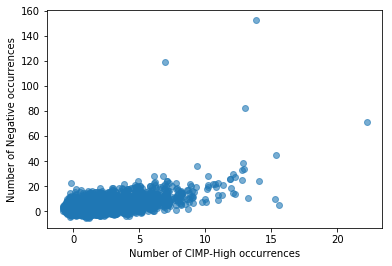

In [4]:
plt.scatter(posCounts, negCounts, alpha=.6)
plt.xlabel("Number of CIMP-High occurrences")
plt.ylabel("Number of Negative occurrences")
plt.show()


#### create lasso scores

In [5]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.001)
clf.fit(rawData, classes)
lassoScores = clf.coef_
print(len(lassoScores))

15947


#### split data by if it has a positive and if it has a negative occurance

In [6]:
never = []
neverMotifNames = []
mixed = []
mixedMotifNames = []
right = []
rightMotifNames = []
bottom = []
bottomMotifNames = []
ratio = []
ratioMotifNames = []
lasso = []
lassoMotifNames = []
for row in range(len(posCounts)):
    if negCounts[row] == 0 and posCounts[row] == 0:
        never.append(tData[row])
        neverMotifNames.append(motifNames[row])
    else:
        if posCounts[row] >= max(posCounts) - 1:
            right.append(tData[row])
            rightMotifNames.append(motifNames[row])
        if negCounts[row] < 3:
            bottom.append(tData[row])
            bottomMotifNames.append(motifNames[row])
        if posCounts[row] > 0 and negCounts[row] > 0:
            mixed.append(tData[row])
            mixedMotifNames.append(motifNames[row])
        if (posCounts[row] / max(posCounts)) / (1+negCounts[row]/max(negCounts)) > .5:
            ratio.append(tData[row])
            ratioMotifNames.append(motifNames[row])
        if lassoScores[row] > 0:
            lasso.append(tData[row])
            lassoMotifNames.append(motifNames[row])            
            
print(len(lasso))

77


#### create a decision tree and train it on mixedData

In [7]:
selected = lasso
selectedNames = lassoMotifNames

selectedTree = tree.DecisionTreeClassifier()
selectedData = [list(i) for i in zip(*selected)]
x_train, x_test, y_train, y_test = train_test_split(selectedData, classes, test_size=0.33)
selectedTree = selectedTree.fit(x_train, y_train)

#### display the tree we've genorated

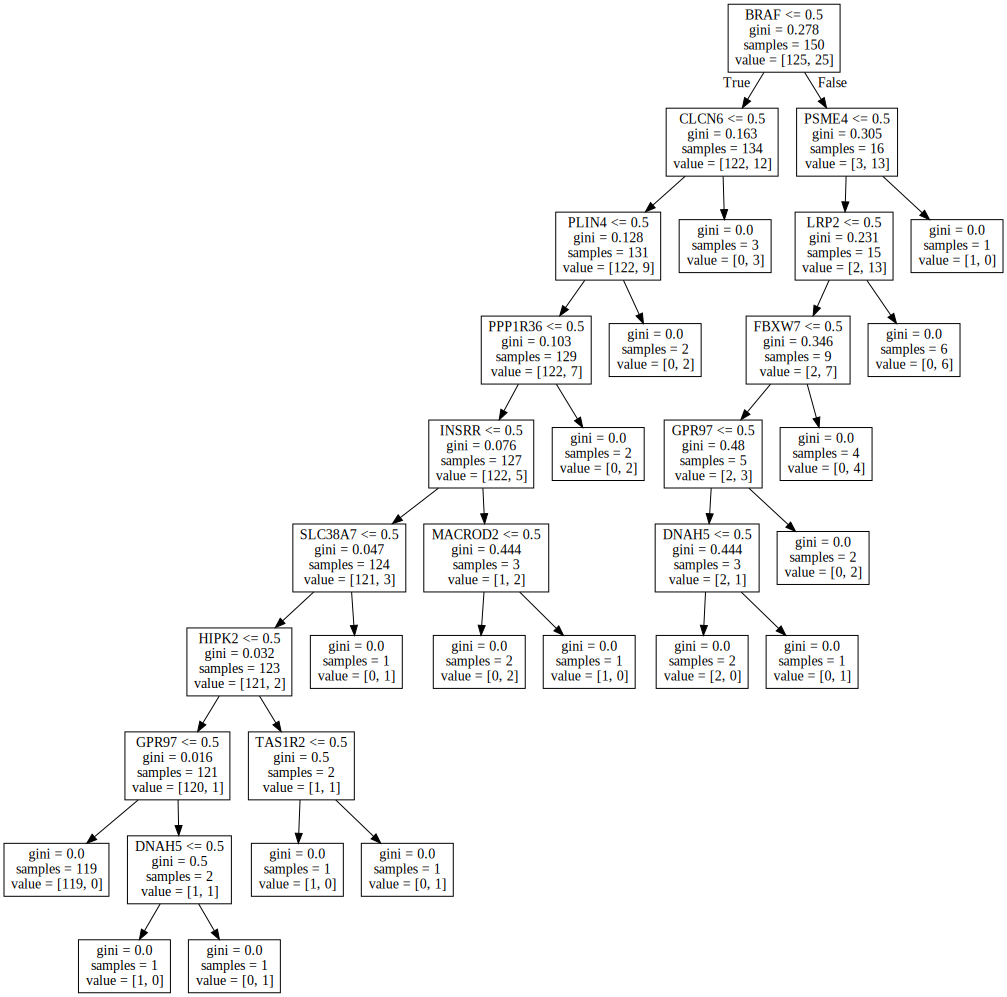

In [8]:
selectedPredictions = selectedTree.predict(x_test)
graph = Source( tree.export_graphviz(selectedTree, out_file=None, feature_names=selectedNames))
SVG(graph.pipe(format='svg'))

#### count true positves, flase negatives etc. and calculate metrics

In [9]:
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(selectedPredictions)):
    if(selectedPredictions[i]):
        if(y_test[i]):
            tp += 1
        else:
            fp += 1
    else:
        if(y_test[i]):
            fn += 1
        else:
            tn += 1
print("true positives:", tp)
print("false positives:", fp)
print("true negatives:", tn)
print("false negatives:", fn)
if fp > 0:
    print("true positive to false positive ratio:",tp/fp)
if fn > 0:
    print("true negative to false negative ratio:",tn/fn)
print("Sensitivity:",tp/(tp+fn))
print("Specificity:",tn/(tn+fp))
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))

true positives: 4
false positives: 3
true negatives: 64
false negatives: 3
true positive to false positive ratio: 1.3333333333333333
true negative to false negative ratio: 21.333333333333332
Sensitivity: 0.5714285714285714
Specificity: 0.9552238805970149
Accuracy: 0.918918918918919


In [10]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.001)
clf.fit(rawData, classes)
print(clf.coef_)

[-0.02431268  0.         -0.         ...,  0.          0.          0.        ]
